In [2]:
#Importation de la librairie Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Openpyxl refuse d'ouvrir les fichiers si l'on n'ignore pas les UserWarnings
# Voir https://stackoverflow.com/questions/54976991/p  ython-openpyxl-userwarning-unknown-extension-issue
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [3]:
#Importation du fichier issu de l’ERP
erp = pd.read_excel('Fichier_erp.xlsx')

#Importation du fichier de la table produit de notre plateforme de vente en ligne
web = pd.read_excel('Fichier_web.xlsx')

#Importation du fichier qui liste les product_id de l’ERP avec leur référence côté Web
liaison = pd.read_excel('fichier_liaison.xlsx')

### Exploration du fichier liaison

In [4]:
#Afficher le nombre de lignes et de colonnes dans le tableau
liaison.shape

(825, 2)

In [5]:
#Exploration du fichier liaison
display(liaison.head())

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [6]:
#Verifiez les types
liaison.dtypes

product_id     int64
id_web        object
dtype: object

In [7]:
#Certains SKU ont des formes non standard.
id_web_outliers = liaison[pd.to_numeric(liaison['id_web'], errors='coerce').isna()]
id_web_outliers['id_web'].unique()

array([nan, 'bon-cadeau-25-euros', '13127-1', '14680-1'], dtype=object)

Il semble que même si ce sont des skus inattendus, ce ne sont pas des valeurs aberrantes. Je vais donc les garder dans le jeu de données.

In [8]:
#Vérifiez si le fichier liaison contient des valeurs manquantes.
print(liaison.isnull().sum())

product_id     0
id_web        91
dtype: int64


C'est ce que mentionnait Sylvie - "La liste des product_id est exhaustive, mais pour les références côté Web, j'en suis moins sûre... J'ai peiné à rapprocher certaines références." Comme nous examinons les produits vendus en ligne, j'ai supprimé les lignes où nous n'avons pas d'identifiant Web pour les produits.

In [9]:
#Supprimer les lignes où id_web = nan
liaison = liaison.dropna(subset=['id_web'])

In [10]:
#Recherche de doublons pour product_id
print(liaison.loc[liaison['product_id'].duplicated(keep=False),:])

Empty DataFrame
Columns: [product_id, id_web]
Index: []


In [11]:
#Recherche de doublons pour web_id
print(liaison.loc[liaison['id_web'].duplicated(keep=False),:])

Empty DataFrame
Columns: [product_id, id_web]
Index: []


In [12]:
#Chercher les valeurs aberrantes
liaison.describe()

,product_id
count,734.000000
mean,5041.859673
std,790.309295
min,3847.000000
25%,4287.250000
50%,4862.500000
75%,5714.250000
max,7338.000000


Aucun doublon dans les deux colonnes.

Sylvie a mentionné qu'elle avait oublié de nommer le sku de la colonne id_web, je vais donc le renommer ici.

In [13]:
#Renommer la colonne id_web à sku.
liaison = liaison.rename(columns={'id_web': 'sku'})

In [14]:
#Determiner si la colonne product_id peut être utilisé comme clé primaire
print("Valeurs uniques dans la colonne product_id = ", liaison['product_id'].nunique())
print("Liaison shape =", liaison.shape)

Valeurs uniques dans la colonne product_id =  734
Liaison shape = (734, 2)


### Exploration du fichier web

In [15]:
#Afficher le nombre de lignes et de colonnes dans le tableau
web.shape

(1513, 28)

In [16]:
#Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

#Imprimer la tête de données
display(web.head())

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,0,0,0,0.0,5.0,NaN,NaN,2.0,2018-06-07 16:27:25,2018-06-07 14:27:25,NaN,Château du Couvent Pomerol 2017,NaN,publish,closed,closed,NaN,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15075,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,NaN,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,publish,closed,closed,NaN,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,16209,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,NaN,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",publish,closed,closed,NaN,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,15763,0,0,0,0.0,1.0,NaN,NaN,2.0,2020-01-25 14:08:16,2020-01-25 13:08:16,NaN,Domaine de la Monardière Vacqueyras Vieilles V...,NaN,publish,closed,closed,NaN,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [17]:
#Verifiez s'il y a des erreurs de type
web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


In [18]:
#Vérifier les valeurs dans la colonne post_author
web['post_author'].unique()

array([ 2., nan,  1.])

Ventes totales - Comme les ventes ne peuvent être comptées qu'en nombres entiers, je dois changer le type de float en entier.
Post author - Comme il n'y a que deux valeurs pour l'auteur (c'est-à-dire l'auteur 1 ou 2), je dois le changer en entier.

In [19]:
#La colonne total_sales est un float alors qu'elle devrait être un integer. Changer la colonne des ventes totales en nombre entier - remplissez NaN, puis changer de type
web['total_sales'] = web['total_sales'].fillna(0)
web['total_sales'] = web['total_sales'].astype(int)

# La colonne post_author est un float alors qu'elle devrait être un integer. Changer la colonne de l'auteur de la publication en nombre entier - remplisser NaN, puis changer de type
web['post_author'] = web['post_author'].fillna(0)
web['post_author'] = web['post_author'].astype(int)

In [20]:
#Vérifier si le fichier web contient des valeurs manquantes
web_na = web.isnull().sum()
web_na[web_na>0]

sku                        85
average_rating             83
tax_status                797
tax_class                1513
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

In [21]:
#Supprimer toutes les colonnes dont toutes les valeurs sont manquantes
web = web.drop(columns=['tax_class', 'post_content', 'post_password', 'post_content_filtered'])

In [22]:
#Vérifiez les données où il n'y a pas de sku, mais il y a des valeurs pour d'autres colonnes
web.loc[(web['sku'].isnull()) & (~web['post_date'].isnull())]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
353,NaN,0,0,0,0.0,3,taxable,2,2018-08-08 11:23:43,2018-08-08 09:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
488,NaN,0,0,0,0.0,10,taxable,2,2018-07-31 12:07:23,2018-07-31 10:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",publish,closed,closed,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [23]:
#Vérifiez si je peux trouver des doublons pour les post_titles pour ces lignes afin de trouver des skus correspondants. 
display(web.loc[web['post_title']== 'Pierre Jean Villa Condrieu Jardin Suspendu 2018'])
display(web.loc[web['post_title']== 'Pierre Jean Villa Côte Rôtie Fongeant 2017'])

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
353,NaN,0,0,0,0.0,3,taxable,2,2018-08-08 11:23:43,2018-08-08 09:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
488,NaN,0,0,0,0.0,10,taxable,2,2018-07-31 12:07:23,2018-07-31 10:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",publish,closed,closed,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [24]:
#Aucune correspondance pour les 2 lignes avec des données mais pas de SKU, donc supprimez toutes les lignes avec des valeurs nulles pour la colonne sku
web = web.dropna(subset=['sku'])

In [25]:
#Vérifier si le fichier web contient des valeurs manquantes
web.isnull().sum()

sku                    0
virtual                0
downloadable           0
rating_count           0
average_rating         0
total_sales            0
tax_status           714
post_author            0
post_date              0
post_date_gmt          0
post_title             0
post_excerpt         714
post_status            0
comment_status         0
ping_status            0
post_name              0
post_modified          0
post_modified_gmt      0
post_parent            0
guid                   0
menu_order             0
post_type              0
post_mime_type       714
comment_count          0
dtype: int64

In [26]:
#Vérifier s'il y a des doublons
web.loc[web['sku'].duplicated(keep=False),:]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,0,0,0,0.0,5,NaN,2,2018-06-07 16:27:25,2018-06-07 14:27:25,Château du Couvent Pomerol 2017,NaN,publish,closed,closed,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
2,15075,0,0,0,0.0,3,taxable,2,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,publish,closed,closed,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,16209,0,0,0,0.0,6,taxable,2,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",publish,closed,closed,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,15763,0,0,0,0.0,1,NaN,2,2020-01-25 14:08:16,2020-01-25 13:08:16,Domaine de la Monardière Vacqueyras Vieilles V...,NaN,publish,closed,closed,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
5,13895,0,0,0,0.0,0,taxable,2,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,"<span style=""display: inline !important; float...",publish,closed,closed,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,12881,0,0,0,0.0,2,NaN,2,2019-03-28 15:25:14,2019-03-28 14:25:14,Domaine de Montbourgeau L'Etoile Vin Jaune 2009,NaN,publish,closed,closed,montbourgeau-etoile-vin-jaune-2009,2019-12-30 10:30:01,2019-12-30 09:30:01,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15663,0,0,0,0.0,3,taxable,2,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,publish,closed,closed,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1510,15910,0,0,0,0.0,0,taxable,2,2019-03-28 10:59:43,2019-03-28 09:59:43,Thevenet Quintaine Viré-Clessé La Bongran 2015,C’est dans cette cuvée la pleine expression du...,publish,closed,closed,thevenet-quintaine-vire-clesse-la-bongran-2015,2020-08-14 10:45:02,2020-08-14 08:45:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1511,38,0,0,0,0.0,38,NaN,2,2018-04-18 12:25:58,2018-04-18 10:25:58,Emile Boeckel Crémant Brut Blanc de Blancs,NaN,publish,closed,closed,emile-boeckel-cremant-brut-blanc-de-blancs,2020-08-27 17:15:03,2020-08-27 15:15:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [27]:
#Vérifier les valeurs dans post_type
web['post_type'].unique()

array(['attachment', 'product'], dtype=object)

Il y a des doublons car pour les produits, il y a des types de pièce jointe et de publication de produit. Je dois supprimer toutes les lignes avec pièce jointe comme valeur.

In [28]:
# Supprimer toutes les lignes avec 'attachment' comme valeur dans la colonne post_type
web = web[web['post_type'] != 'attachment']
#Vérifiez s'il y a des doublons
web.loc[web[['sku', 'post_title']].duplicated(keep=False),:]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count


In [29]:
#Identifiez les colonnes avec toutes les valeurs 0 ou nan et vérifiez les valeurs aberrantes
web.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_parent,menu_order,comment_count
count,714.0,714.0,714.0,714.0,714.000000,714.000000,714.0,714.0,714.0
mean,0.0,0.0,0.0,0.0,4.012605,1.998599,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.518183,0.037424,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,2.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,2.000000,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,2.000000,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,2.000000,0.0,0.0,0.0


In [30]:
#Supprimer les colonnes avec toutes les valeurs nulles ou avec tous les zéros
web = web.drop(columns=['virtual', 'downloadable', 'rating_count', 'average_rating', 'post_parent', 'menu_order', 'comment_count'])
#Supprimer les colonnes qui ne seront pas utilisées pour l'analyse
web = web.drop(columns=['tax_status', 'post_author', 'post_date', 'post_date_gmt', 'post_excerpt', 'comment_status', 'ping_status', 'post_name', 'post_modified', 'post_modified_gmt', 'guid', 'post_type', 'post_status', 'post_mime_type']).reset_index().drop(columns='index')

In [31]:
#Déterminer si SKU peut être utilisé comme clé primaire
print("Valeurs uniques dans la colonne SKU = ", web['sku'].nunique())
print("Web shape =", web.shape)

Valeurs uniques dans la colonne SKU =  714
Web shape = (714, 3)


In [32]:
web.head()

,sku,total_sales,post_title
0,15075,3,Parés Baltà Penedès Indigena 2017
1,16209,6,Maurel Cabardès Tradition 2017
2,13895,0,Château Saransot-Dupré Bordeaux Blanc 2016
3,12857,0,Château de Meursault Puligny-Montrachet 1er Cr...
4,14106,0,Stéphane Tissot Château-Chalon 2011


### Exploration du fichier ERP

In [33]:
#Exploration du fichier ERP
display(erp.head())

erp.shape

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


(825, 5)

In [34]:
#Verifiez s'il y a des erreurs de type
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

In [35]:
#Vérifiez si le fichier ERP contient des valeurs manquantes
erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [36]:
#Vérifiez s'il y a des doublons
erp.loc[erp['product_id'].duplicated(keep=False),:]

,product_id,onsale_web,price,stock_quantity,stock_status


In [37]:
#Détection des outliers 
erp.describe()

,product_id,onsale_web,price,stock_quantity
count,825.000000,825.000000,825.000000,825.000000
mean,5162.597576,0.869091,32.384000,26.583030
std,902.644635,0.337506,26.832271,45.875948
min,3847.000000,0.000000,-8.000000,-1.000000
25%,4348.000000,1.000000,14.600000,1.000000
50%,4907.000000,1.000000,24.400000,11.000000
75%,5805.000000,1.000000,42.000000,34.000000
max,7338.000000,1.000000,225.000000,578.000000


Valeurs aberrantes pour le prix et la quantité de stock - les valeurs négatives ne peuvent pas exister.

In [38]:
erp.loc[erp['price']<0]

,product_id,onsale_web,price,stock_quantity,stock_status
469,5017,0,-8.0,0,outofstock
739,6594,0,-1.0,192,instock


In [39]:
#Comme nous sommes intéressés par l'analyse des prix et du chiffre d'affaires, et que nous pouvons être sûrs des prix réels, nous devons supprimer les lignes avec des valeurs négatives pour les prix
erp = erp[erp['price']>0]

Maintenant, je dois vérifier les colonnes stock quantity and stock status

In [40]:
#Vérifier les valeurs de stock_status
print('Stock_status values =', erp['stock_status'].unique())

Stock_status values = ['outofstock' 'instock']


In [41]:
#Trouve les negative values dans la colonne stock_quantity
display(erp.loc[erp['stock_quantity']<0,:])


,product_id,onsale_web,price,stock_quantity,stock_status
449,4973,0,10.0,-1,outofstock
573,5700,1,44.5,-1,outofstock


In [42]:
#Remplacer les valeurs dans les cellules avec des valeurs negatifs pour stock quantity avec un zéro, parce que stock_status est 'out of stock'.
erp.loc[erp['stock_quantity']<0,'stock_quantity'] = 0

In [43]:
#Identifier où la quantité de stock est 0, mais le statut de stock est instock
erp.loc[(erp['stock_quantity'] == 0) & (erp['stock_status'] == 'instock')]

,product_id,onsale_web,price,stock_quantity,stock_status
443,4954,1,25.0,0,instock


In [44]:
#Changer l'état du stock en rupture de stock
mask = (erp['stock_quantity'] == 0) & (erp['stock_status'] == 'instock')
erp.loc[mask, 'stock_status'] = 'outofstock'

In [45]:
#Identifiez où la quantité de stock est supérieure à 0, mais l'état du stock est en rupture de stock
erp.loc[(erp['stock_quantity'] > 0) & (erp['stock_status'] == 'outofstock')]

,product_id,onsale_web,price,stock_quantity,stock_status
19,4055,0,86.1,1,outofstock
49,4090,0,73.0,6,outofstock
50,4092,0,47.0,6,outofstock
630,5826,1,41.2,12,outofstock
696,6125,0,14.2,48,outofstock


In [46]:
# Changer le statut du stock en instock lorsque la quantité de stock est supérieure à 0
mask = (erp['stock_quantity'] > 0) & (erp['stock_status'] == 'outofstock')
erp.loc[mask, 'stock_status'] = 'instock'

In [47]:
#Déterminer si l'ID produit peut être utilisé comme clé primaire
print("Valeurs uniques dans la colonne product_id = ", erp['product_id'].nunique())
print("ERP shape =", erp.shape)

Valeurs uniques dans la colonne product_id =  823
ERP shape = (823, 5)


### Merge of Tables

In [67]:
#Vérifier la forme de chaque dataframe
print('Web shape =', web.shape)
print('Liaison shape =', liaison.shape)
print('ERP shape =', erp.shape)

Web shape = (714, 3)
Liaison shape = (734, 2)
ERP shape = (823, 5)


In [68]:
#Fusionner les tables
erp_liaison = pd.merge(erp, liaison, on='product_id', how='left')
erp_web = pd.merge(erp_liaison, web, on='sku', how='inner')
erp_web.shape

(714, 8)

In [69]:
display(erp_web.head())

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_title
0,3847,1,24.2,0,outofstock,15298,6,Pierre Jean Villa Saint-Joseph Préface 2018
1,3849,1,34.3,0,outofstock,15296,0,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017
2,3850,1,20.8,0,outofstock,15300,0,Pierre Jean Villa Crozes-Hermitage Accroche Co...
3,4032,1,14.1,0,outofstock,19814,3,Pierre Jean Villa IGP Collines Rhodaniennes Ga...
4,4039,1,46.0,0,outofstock,19815,0,Pierre Jean Villa Côte Rôtie Carmina 2017


In [74]:
#Vérifier s'il y a des valeurs nulles
erp_web.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
sku               0
total_sales       0
post_title        0
dtype: int64

In [78]:
#Faire la colonne du chiffre d'affaires 
erp_web['chiffre_daffaires'] = erp_web['price']*erp_web['total_sales']
#Total chiffre d'affaires
ca_totale_enligne = erp_web.loc[erp_web['onsale_web']==1]
ca_totale_enligne = round(ca_totale_enligne['chiffre_daffaires'].sum(),2)

print('Le total du chiffre d’affaires réalisé en ligne est €', ca_totale_enligne)

Le total du chiffre d’affaires réalisé en ligne est € 70568.6


In [79]:
#Afficher le chiffre d'affaires de chaque produit.
CA = erp_web[['post_title', 'price', 'chiffre_daffaires']]
CA = CA.sort_values(by='chiffre_daffaires', ascending=False)
CA_nonulls = CA[~CA['chiffre_daffaires'].isnull()]
CA_nonulls

,post_title,price,chiffre_daffaires
194,Champagne Gosset Grand Blanc de Blancs,49.0,4704.0
71,Champagne Gosset Grand Rosé,49.0,4263.0
218,Cognac Frapin VIP XO,176.0,2288.0
70,Champagne Gosset Grand Millésime 2006,53.0,1590.0
69,Champagne Gosset Grande Réserve,39.0,1560.0
...,...,...,...
352,Maurice Schoech Pinot Noir Pièce de Chêne 2016,13.6,0.0
351,Maurice Schoech Riesling 2018,11.1,0.0
348,Maurice Schoech Gewurztraminer 2018,12.1,0.0
346,Maurice Schoech Riesling Vendanges Tardives 2017,28.5,0.0


In [80]:
CA_nonulls.head(10)

,post_title,price,chiffre_daffaires
194,Champagne Gosset Grand Blanc de Blancs,49.0,4704.0
71,Champagne Gosset Grand Rosé,49.0,4263.0
218,Cognac Frapin VIP XO,176.0,2288.0
70,Champagne Gosset Grand Millésime 2006,53.0,1590.0
69,Champagne Gosset Grande Réserve,39.0,1560.0
201,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,1391.5
199,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,1125.0
79,Elian Daros Côtes du Marmandais Clos Baquey 2015,29.0,1044.0
651,Domaine Giudicelli Patrimonio Blanc 2019,25.2,1033.2
30,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16.6,1029.2


In [81]:
#Pourcentage du chiffre d'affaires de top 3 produits
print('3 de nos produits représentent', round(((4704+4263+2288)/70568.6)*100, 2), "% de notre chiffre d'affaires total.")
produits_sans_chiffre = CA_nonulls.loc[CA_nonulls['chiffre_daffaires']==0, 'chiffre_daffaires'].count()
print(round(produits_sans_chiffre/CA_nonulls['chiffre_daffaires'].count(), 2)*100, "% de nos produits n'ont pas de chiffre d'affaires")

3 de nos produits représentent 15.95 % de notre chiffre d'affaires total.
46.0 % de nos produits n'ont pas de chiffre d'affaires


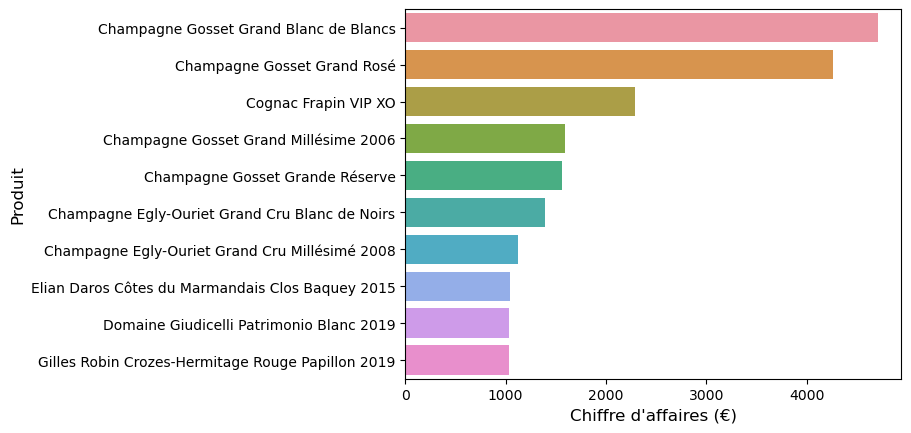

In [82]:
top10 = CA_nonulls.head(10)
sns.barplot(data=top10, y='post_title', x='chiffre_daffaires', estimator=sum)
sns.set_palette('Set2')
plt.xlabel("Chiffre d'affaires (€)", fontsize = 12)
plt.ylabel('Produit', fontsize = 12)
plt.show()

# Price analysis

In [83]:
#Regarder les quantiles pour la colonne de prix
erp_web['price'].describe()

count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64

In [84]:
#Méthode Method
quartiles = erp_web['price'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
print('IQR =', iqr)

print('IQR Outliers = Produits avec un prix <', round(erp_web['price'].quantile(0.25)-(round((iqr*1.5), 2)),2), '€')
print('ou IQR Outliers = Produits avec un prix >', erp_web['price'].quantile(0.75)+(round((iqr*1.5), 2)), '€')

IQR = 28.075000000000003
IQR Outliers = Produits avec un prix < -28.01 €
ou IQR Outliers = Produits avec un prix > 84.285 €


In [88]:
#Trouver des valeurs aberrantes - Je ne regarde que les valeurs élevées, car 14,65 moins l'IQR est un nombre négatif, et les prix ne peuvent pas être négatifs.
outliers = erp_web.loc[(erp_web['price'] > erp_web['price'].quantile(0.75) + iqr)]
outliers = outliers[['product_id', 'post_title', 'price']].sort_values(by='price', ascending=False).reset_index().drop(columns='index')
print('Valeurs aberrantes totales =', outliers['product_id'].count())
display(outliers.head(50))
display(outliers.tail(13))

Valeurs aberrantes totales = 56


,product_id,post_title,price
0,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0
1,5001,David Duband Charmes-Chambertin Grand Cru 2014,217.5
2,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3
3,4402,Cognac Frapin VIP XO,176.0
4,5767,Camille Giroud Clos de Vougeot 2016,175.0
5,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0
6,4904,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0
7,6126,Champagne Gosset Célébris Vintage 2007,135.0
8,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5
9,5612,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8


,product_id,post_title,price
43,4073,Château de Vaudieu Châteauneuf-du-Pape L'Avenu...,77.8
44,4139,Zind-Humbrecht Gewurztraminer Grand Cru Rangen...,77.4
45,4358,Champagne Larmandier-Bernier Grand Cru Vieille...,77.0
46,4631,Marcel Windholtz Eau de Vie de Baie de Houx,76.8
47,6106,Stéphane Tissot Château-Chalon 2011,74.8
48,5951,Domaine de Vaccelli AOP Ajaccio Rouge Granit 1...,74.5
49,5741,Domaine Clerget Chambolle-Musigny Les Charmes ...,73.3
50,6568,Decelle-Villa Chambolle-Musigny 2017,72.0
51,6041,Château de Vaudieu Châteauneuf-du-Pape Amiral ...,71.7
52,4054,Clos du Mont-Olivet Châteauneuf-du-Pape Cuvée ...,71.6


moy:
 32.49
med:
 23.55
mod:
 0    19.0
Name: price, dtype: float64
var:
 772.3420677486691
ect:
 27.791042941002935
skw:
 2.58090126300337
kur:
 10.088392064977288


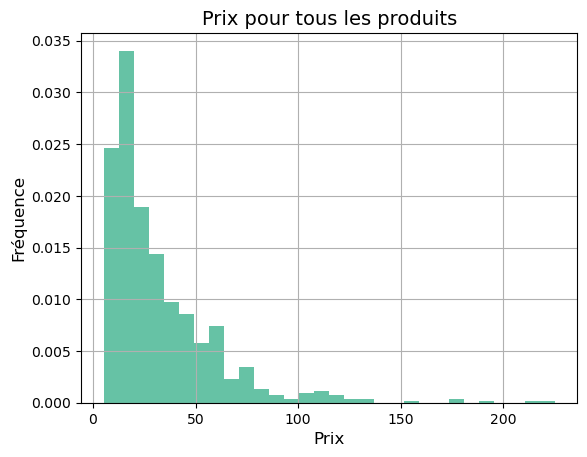

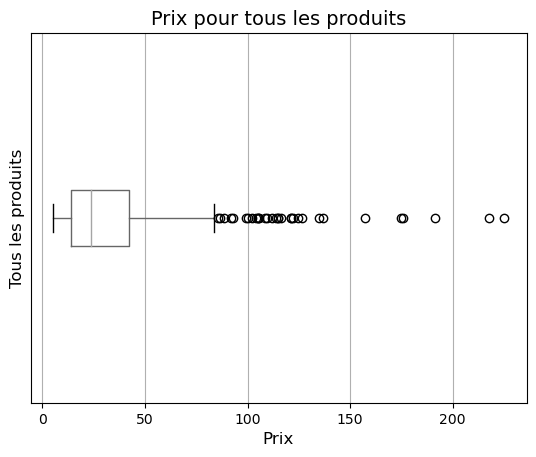

In [89]:
print("moy:\n",round(erp_web["price"].mean(), 2))
print("med:\n",erp_web["price"].median())
print("mod:\n",erp_web["price"].mode())
print("var:\n",erp_web["price"].var(ddof=0))
print("ect:\n",erp_web["price"].std(ddof=0))
print("skw:\n",erp_web["price"].skew())
print("kur:\n",erp_web["price"].kurtosis())
    
erp_web[erp_web["price"].abs() < 250]["price"].hist(density=True,bins=30)
plt.title("Prix pour tous les produits", fontsize=14)
plt.xlabel('Prix', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.show()   

erp_web.boxplot(column="price", vert=False)
plt.title("Prix pour tous les produits", fontsize=14)
plt.xlabel('Prix', fontsize=12)
plt.ylabel('Tous les produits', fontsize=12)
plt.yticks([])
plt.show()

Text(0, 0.5, 'Produit')

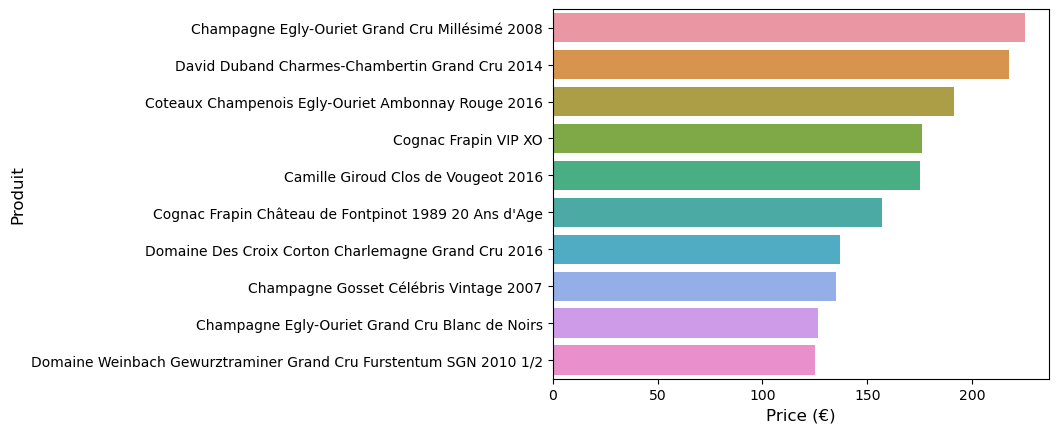

In [90]:
#Les 10 produits avec le prix le plus élevé
top10prix = erp_web.sort_values(by='price', ascending=False).head(10)
sns.barplot(data=top10prix, y='post_title', x='price', estimator=sum)
sns.set_palette('Set2')
plt.xlabel("Price (€)", fontsize = 12)
plt.ylabel('Produit', fontsize = 12)